### Some imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

2024-05-19 09:50:03.655300: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 09:50:03.826078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 09:50:04.502740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")

In [3]:
tsla_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## PART I

In [4]:
# Load Tesla stock data
tesla_data = tsla_df

# Ensure Date is the index
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

# Sort data by date
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

# Use 'Close' price for prediction
data = tesla_data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data to fit LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [5]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.4592e-04 - val_loss: 0.0069
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.7703e-06 - val_loss: 0.0057
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.7383e-06 - val_loss: 0.0043
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.0268e-06 - val_loss: 0.0043
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 5.0642e-06 - val_loss: 0.0034
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.6415e-06 - val_loss: 0.0045
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.6661e-06 - val_loss: 0.0036
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.7552e-06 - val_loss: 0.0025
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.9508e-06 - val_loss: 0.0034
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8909e-06 - val_loss: 0.0032


In [6]:
# Predict and inverse transform the scaled data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f'RMSE: {rmse}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 69.73253438248044


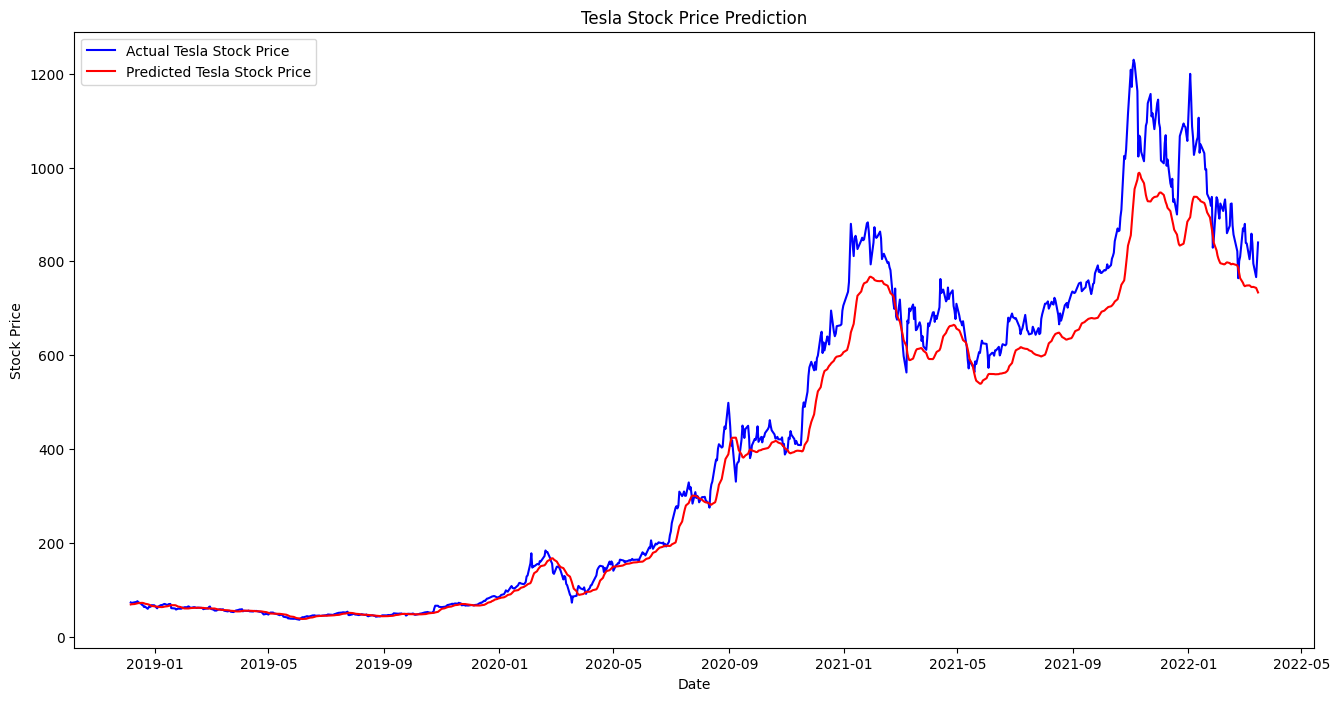

In [7]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [17]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])


# Merge Tesla and gold data on date
combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = combined[['Date', 'Close_x', 'Close_y']]

# Normalize combined data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data[['Close_x', 'Close_y']])

In [18]:
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [19]:
X, Y = create_dataset_with_gold(scaled_combined_data, seq_length)

# Split the data into training and testing sets (70% training, 30% testing)
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [20]:
# Define the LSTM model
model_comb = Sequential()
model_comb.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 2)))
model_comb.add(LSTM(50, return_sequences=False))
model_comb.add(Dense(25))
model_comb.add(Dense(2))

# Compile the model
model_comb.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Train the model
history_comb = model_comb.fit(X_train, Y_train, batch_size=32, epochs=10)
# history_comb = model_comb.fit(X_train_comb, y_train_comb, epochs=10, batch_size=32, validation_data=(X_test_comb, y_test_comb))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0105
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.7049e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2414e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.1494e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.4509e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.9147e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.2939e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.9039e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4598e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.9310e-04


In [22]:
train_predict = model_comb.predict(X_train)
test_predict = model_comb.predict(X_test)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [23]:
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)

train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print(f'Train MAE (with gold): {train_mae}, Train RMSE (with gold): {train_rmse}')
print(f'Test MAE (with gold): {test_mae}, Test RMSE (with gold): {test_rmse}')

Train MAE (with gold): 0.0098379462190436, Train RMSE (with gold): 0.01681923066544847
Test MAE (with gold): 0.06582912053831455, Test RMSE (with gold): 0.10428091570315914


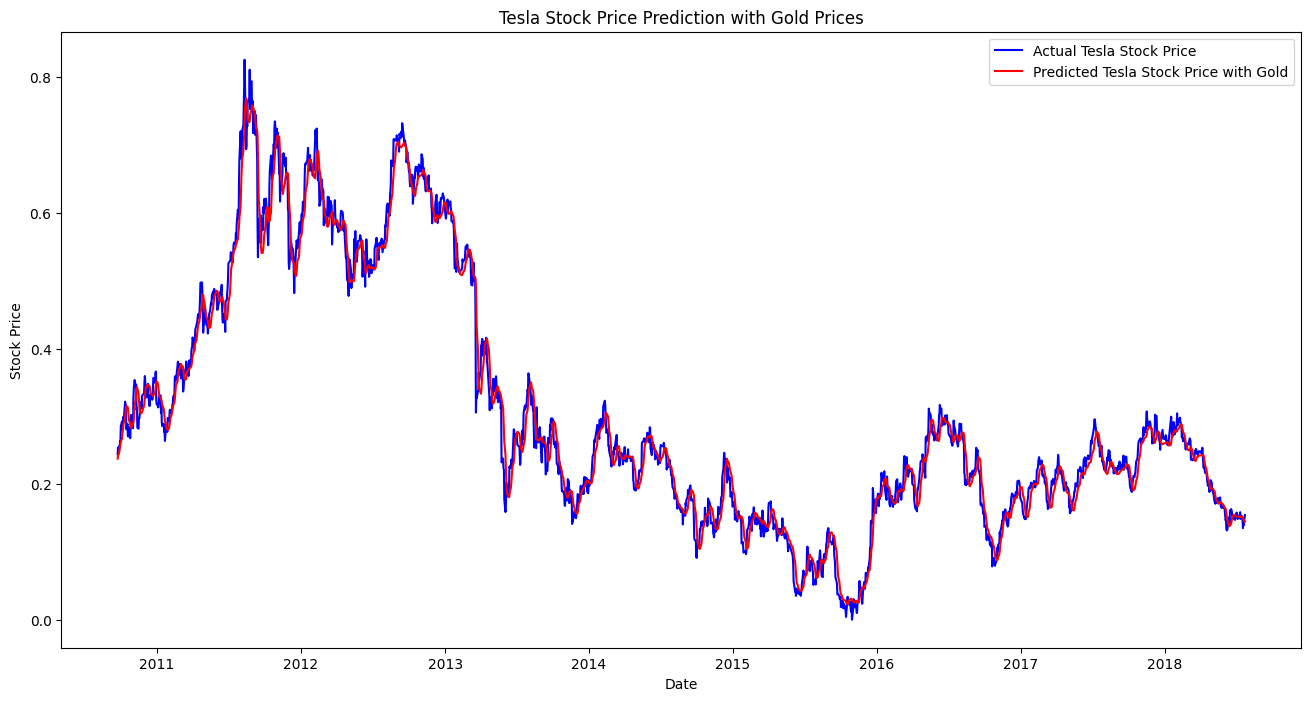

In [24]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], Y_train[:,1], color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], train_predict[:,1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()